# Primary implementation: 
# LSTM model with GloVE embeddings

***

## 1. Setting up the environment
### This section contains the required packages, used seed and device initializations

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
from torchsummary import summary
from pylab import array

# Model and training
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
from tqdm import tqdm
from transformers import DistilBertTokenizer
from transformers import AdamW 
import pickle

# Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# Utils
from datetime import datetime

# Vocabulary and embedding
import zipfile

In [2]:
# Setting the random seeds to make predictions more controlled
seed_value = 42

np.random.seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

In [3]:
cuda.is_available()

True

In [4]:
device = 'cuda' if cuda.is_available() else 'cpu'

## 2. Preprocessing data
### Contains helper functions and their configuration for data cleaning.

In [5]:
#  Configuration for preprocessing function that reads in and cleans the data.
#  It also separates datasets and produces training and validation sets.
#  Parameters: 
#                 csv_name : relative path to the input csv file
#                 test_size: the percent of the whole dataset to be used for validation
#                      rows: number of rows to read in (0 means full dataset)
#     negative_percent_drop: the percent of the negative samples to remove from dataset (1 means 100%)

preprocess_params = {
    'csv_name':'input/jigsaw-toxic-comment-classification-challenge/train.csv.zip',
    'test_size': 0.4,
    'rows': 0,
    'negative_percent_drop': 0.97,
}

In [6]:
#  Fuction to prepare the comments
#  Lowercases them, filters out the extra whitespaces, expands abbreviations.

def text_transform(text): 
    _lower_case = re.sub(r'[^A-Za-z0-9 ]+', ' ', text.lower())
    _multiple_whitespaces = re.compile(r"\s+")
    _filtered = _multiple_whitespaces.sub(" ", _lower_case).strip()
    _filtered = re.sub(r"n\'t", " not",  _filtered)
    _filtered = re.sub(r"\'re", " are",  _filtered)
    _filtered = re.sub(r"\'s", " is",  _filtered)
    _filtered = re.sub(r"\'d", " would",  _filtered)
    _filtered = re.sub(r"\'ll", " will",  _filtered)
    _filtered = re.sub(r"\'t", " not",  _filtered)
    _filtered = re.sub(r"\'ve", " have",  _filtered)
    filtered = re.sub(r"\'m", " am",  _filtered)
    return filtered

#  Cleaning fuction. Removes negatives according to the given percent, removes unused fields, sets field types.

def df_cleaner(dataframe, percent):
    
    negatives = len(dataframe[(dataframe['toxic']==0) &
                              (dataframe['severe_toxic']==0) &
                              (dataframe['obscene']==0) &
                              (dataframe['threat']==0) &
                              (dataframe['insult']==0) &
                              (dataframe['identity_hate']==0)
                             ])
    
    dataframe.drop(['id'], inplace=True, axis=1)
    
    # Dropping out the n percent of negative samples 
    dataframe.drop(dataframe[(dataframe['toxic']==0) &
                             (dataframe['severe_toxic']==0) &
                             (dataframe['obscene']==0) &
                             (dataframe['threat']==0) &
                             (dataframe['insult']==0) &
                             (dataframe['identity_hate']==0)
                            ].index[:int(negatives*percent)] , inplace=True)
    
    dataframe = dataframe.astype({"comment_text":'string',
                                  "toxic":'int8',
                                  "severe_toxic":'int8',
                                  "obscene":'int8',
                                  "threat":'int8',
                                  "insult":'int8',
                                  "identity_hate":'int8',
                                 })
    dataframe['comment_text'] = dataframe['comment_text'].map(text_transform) 
    return dataframe


#  Function for reprocessing the Kaggle toxic-comment-classification dataset.
#  Creates raw input and label sets for training and test purposes.
#  Main function of this section.
#      Returns: x_train , x_val , y_train , y_val 

def kaggle_toxic_preprocess(csv_name, test_size, rows, negative_percent_drop):
    
    data_frame = pd.read_csv(csv_name,  nrows=rows).fillna(' ') if rows != 0 else pd.read_csv(csv_name).fillna(' ')
    data_frame = df_cleaner(data_frame, negative_percent_drop)    
    
    x = list(map(text_transform, data_frame['comment_text'].values))
    # Unify labels
    y = np.array([[t['toxic'],
                   t['severe_toxic'],
                   t['obscene'],
                   t['threat'],
                   t['insult'],
                   t['identity_hate'],
                  ] for (_,t) in data_frame.iterrows()])
    
    del data_frame
    
    return train_test_split(x, y, test_size=test_size ,random_state = 1)

In [7]:
#  Entry point of the section

x_train , x_val , y_train , y_val = kaggle_toxic_preprocess(**preprocess_params)

## 3. Dataset and DataLoader
### Contains the main data structures

In [8]:
#  Configuration for tokenization.
#  Parameters: 
#                 tokenizer : class of tokenizer to use
#                 configname: pretrained tokenizer base to use 
#           tokenizer_params: additional parameters of the tokenizer
#         add_special_tokens: whether or not to encode the sequences with the special tokens
#                    padding: controls padding strategy
#             return_tensors: tensor type to return
#                 max_length: maximum length of tokenized text
#                 truncation: controls truncation strategy

token_vars = {
    'tokenizer': 'DistilBertTokenizer',
    'configname' : 'distilbert-base-uncased',
    'tokenizer_params': {
        'add_special_tokens' : True,
        'padding':'max_length',
        'return_tensors':'pt',
        'max_length': 240,
        'truncation':True,
    },
    'enc_type': torch.FloatTensor, 
    'device' : device,
}

In [9]:
#  Configuration of the DataLoader.
#  Parameters: 
#                 batch_size: size of the data chunks to feed the model with
#                num_workers: number of loader worker processes

loader_vars = {
    'batch_size': 10,
    'num_workers': 0,
}

In [10]:
#  Main configuration for the DataSets and DataLoaders

data_config = {
    'tokenizer_config': token_vars,
    'loader_config': loader_vars,
}

In [11]:
#  Dataset with bulit-in encoding.
#  Returns the tokenized and the original text and labels transformed into torch tensors.
#  All values are tranferred to GPU. 

class tokenizedToxicDataset(Dataset):
    
    def __init__(self, comments, labels, tokenizer, configname, tokenizer_params, enc_type, device):
        self.comments = comments
        self.labels = labels
        
        # Text evaluation must not appear in production code due to security concerns
        _tokenizer = eval(tokenizer)
        
        self.tokenizer = _tokenizer.from_pretrained(configname)
        self.tokenizer_params = tokenizer_params
        self.enc_type = enc_type
        self.device = device
        
    def __len__(self):
        return len(self.labels)
  
    def __getitem__(self, idx):
        comment = self.comments[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(comment, **self.tokenizer_params)
        encoding = torch.LongTensor(encoding['input_ids'][0]).to(self.device)
        encoding = encoding.type(self.enc_type)
                
        label = torch.tensor(label, dtype=torch.float).to(self.device)
        
        return encoding, label, comment       

In [12]:
#  Dataloader with built-in tokenizer (DataSet)

def tokenized_toxic_dataloader(x_set, y_set, tokenizer_config, loader_config):
    data = tokenizedToxicDataset(
        comments=x_set,
        labels=y_set,
        **tokenizer_config,
    )
 
    return DataLoader(
        data,
        shuffle=True,
        **loader_config,
    )

In [13]:
#  Entry point of the section

training_loader = tokenized_toxic_dataloader(x_train, y_train, **data_config)
test_loader = tokenized_toxic_dataloader(x_val, y_val, **data_config)

## 4. GloVE embedding
### Prepares the weight matrix 

In [14]:
#  Configuration for weight matrix creation.
#  Parameters: 
#                glove_file: relative path to glove file
#                target_dir: place to extract the content
#                embedding_file: embedding file to use 

weight_matrix_config = {
    "glove_file": "input/glove.6B.zip",
    "target_dir": "input/glove.6B",
    "embedding_file": "glove.6B.50d.txt",
}

In [15]:
#  Fuction to create weight matrix with proper dimensions.

def weight_matrix(glove_file, target_dir, embedding_file):
    with zipfile.ZipFile(glove_file, "r") as zip_ref:
        zip_ref.extractall(target_dir)
    
    _path = target_dir + "/" + embedding_file
    _glove = pd.read_csv(_path, sep=" ", quoting=3, header=None, index_col=0)
    
    glove_embedding = {key: val.values for key, val in _glove.T.items()}
    
    _matrix_len = len(glove_embedding)
    # extract dimension from filename
    _dimension = int(embedding_file.split('.')[-2][:-1])
    
    weights_matrix = np.zeros((_matrix_len, _dimension))
    
    for i, word in enumerate(glove_embedding):
        try: 
            weights_matrix[i] = glove_embedding[word]
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(_dimension, ))
    
    return torch.from_numpy(weights_matrix)

In [16]:
#  Entry point of the section

weights_matrix = weight_matrix(**weight_matrix_config)

## 5. Model
### Describes model structure. The parameterization in case of models is intentionally limited.

In [17]:
#  Configuration of the model.
#  Parameters: 
#                layer_num: number of LSTM layers
#                output_dim: number of output classes
#                text_lenght: maximum length of tokenized inputs

model_config = {
    "layer_num": 3,
    "output_dim": 6, 
    "text_length": token_vars["tokenizer_params"]["max_length"]
}

In [18]:
#  Model structure.
#  Bidirectional LSTM with pretrained embedding layer.
#  Output dimensions are formed by liner layer.
#  Normalization is performed on batch level.

class LSTMClass(nn.Module):
    def __init__(self, emb_matrix, layer_num, output_dim, text_length):
        super(LSTMClass, self).__init__()
                    
        self.hidden_dim = output_dim // 2
        self.layer_num = layer_num
        
        # freeze is set so the embeddings don't get updated during learning
        self.embedding = nn.Embedding.from_pretrained(emb_matrix, freeze=True)
        
        self.lstm = nn.LSTM(weights_matrix.shape[1],
                            self.hidden_dim, self.layer_num,
                            bidirectional=True, batch_first=True
                           )
        self.linear = nn.Linear(text_length, 1)
        self.bn1 = nn.BatchNorm1d(num_features=output_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, input_ids, batch_size):
        
        embedded = self.embedding(input_ids)
        outputs = self.lstm(embedded.float())
        outputs = torch.reshape(outputs[0], (batch_size, outputs[0].shape[2], outputs[0].shape[1]))
        outputs = self.activation(self.bn1(self.linear(outputs)))
        outputs = outputs.squeeze()
        
        return outputs    
        

In [19]:
#  Model is tranferred to GPU

lstm_model = LSTMClass(weights_matrix, **model_config)
lstm_model.to(device)

LSTMClass(
  (embedding): Embedding(399998, 50)
  (lstm): LSTM(50, 3, num_layers=3, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=240, out_features=1, bias=True)
  (bn1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): Sigmoid()
)

## 6. Optimalization methods
### Prepares scheduler, loss function and optimizer

In [20]:
#  Configuration of the optimizer functions.
#  Parameters: 
#                loss_fn_weights: class weights to use in BCE loss function
#                scheduler_params: parameters of the custom scheduler
#                base_lr: maximum learning rate
#                stop_factor_lr: minimum learning rate
#                factor: decreasing factor of the learning rate

#[0.0436, 1-0.045, 1-0.241, 1-0.014, 1-0.224, 1-0.04]
#[0.0436, 0.045, 0.241, 0.014, 0.224, 0.04]

optim_config = {
    'loss_fn_weights' : [1,10,4,11,5,15],
    'scheduler_params': {
        'base_lr' : 1e-3,
        'stop_factor_lr' : 1e-5,
        'factor' : 0.8,
    },
    'device' : device,
    'model_params': lstm_model.parameters(),
}

In [21]:
#  Custom scheduler for dynamic learning rate adjustment
#  Changing the learning rate based on the actual epoch

class FactorScheduler:
    def __init__(self, factor, stop_factor_lr, base_lr):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

In [22]:
#  Initializer function for loss fuction, scheduler and optimizer

def optimizer_methods(loss_fn_weights, scheduler_params, device, model_params):
    # Weighted BCE loss function
    def loss_fn(outputs, targets):
        pos_weight = torch.tensor(loss_fn_weights).to(device)
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        return criterion(outputs, targets)

    optimizer = AdamW(model_params, lr=scheduler_params['base_lr'])
    scheduler = FactorScheduler(**scheduler_params)
    
    return loss_fn, optimizer, scheduler

In [23]:
# Entry point of this section

loss_fn, optimizer, scheduler = optimizer_methods(**optim_config)

## 7. Training loop
### Trains the model while measures performance

In [24]:
#  The body of an epoch

def epoch_body(model, epoch, device, data_loader, optimizer, criterion, scheduler, batch_size, input_len, train=True):
    
    # Local accumulators
    running_loss = 0.0
    correct = 0.0
    total = 0

    y_truth = []
    y_prediction = []
    
    # Changing the mode of the model
    if train:
        model.train()
    else: 
        model.eval()
 
    # Iterate through the loader elements (train or test)
    for i, data in tqdm(enumerate(data_loader, 0)):

        encodings, targets, texts = data
        encodings = encodings.type(torch.LongTensor).to(device)
            
        if train:
            # Clean the gradients of the previous mini batch
            optimizer.zero_grad()
            
            if epoch == 0 and i == 1: 
                summary(model, encodings, batch_size, branching=False, col_width=16, col_names=["kernel_size", "output_size", "num_params", "mult_adds"],)
            
        if encodings.shape == (batch_size, input_len):
            outputs = model(encodings, batch_size)
            
            if i == 400:
                print(outputs)
            
            loss = criterion(outputs, targets)
            
            if i == 400:
                print(loss)
            
            running_loss += float(loss)
            
            # Calculate correct predictions by rounding outputs to the closest integer
            predicted = torch.round(outputs)
            correct_prediction = torch.eq(predicted, targets).float()
            
            correct += torch.sum(correct_prediction)

            total += torch.numel(targets)
            
            # Accuracy based on rounded values
            accuracy = torch.mean(correct_prediction.type(torch.cuda.FloatTensor))

            if train:
                # In case of training we backpropagate the gradients
                loss.backward()
                optimizer.step()
                
            y_prediction.append(predicted.cpu().detach())
            y_truth.append(targets.cpu().detach())
                
            
            del outputs
        
        # Empty GPU cache to save memory
        torch.cuda.empty_cache()
   
        del texts
        del encodings
        del targets
        del data 
    
    # Adjust scheduler
    if scheduler:
        try:
            for param_group in optimizer.param_groups:
                param_group['lr'] = scheduler()
        except:
            scheduler.step()
       
    y_prediction = np.concatenate(y_prediction)
    y_truth = np.concatenate(y_truth)
    
    # Epoch level evaluation
    f1 = f1_score(y_prediction, y_truth, average='samples')
    loss = running_loss / len(data_loader)
    corr = (correct / total * 100).cpu()

    print("%s epoch %s loss: %.3f correct: %.2f f1_score: %.3f" % (epoch, "Training" if train else "Validating", loss, corr, f1))
    
    return loss, corr, f1, y_prediction.astype(np.float), y_truth.astype(np.float)

In [25]:
#  Trainer function

def epoch_loop(model, num_epoch, device, train_loader, eval_loader, optimizer, scheduler, criterion, batch_size, input_len):
   
    loss = []
    accuracy = [] 
    f1 = [] 
    predictions = []
    truth = []
    
    for i, epoch in enumerate(range(num_epoch)):    
        train_loss, train_acc, train_f1, train_pred, train_truth = epoch_body(
            model, epoch, device,
            train_loader, optimizer, criterion, scheduler,
            batch_size, input_len,
            train=True) 
        
        test_loss, test_acc, test_f1, test_pred, test_truth = epoch_body(
            model, epoch, device,
            eval_loader, optimizer, criterion, scheduler,
            batch_size, input_len,
            train=False) 
        
        loss.append((train_loss, test_loss))
        accuracy.append((train_acc, test_acc))
        f1.append((train_f1, test_f1))
        
        predictions.append(train_pred)
        predictions.append(test_pred)
        
        truth.append(train_truth)
        truth.append(test_truth)
        
    return loss, accuracy, f1, predictions, truth

In [26]:
#  Runs 20 epoch 
loss, accuracy, f1, predictions, truth = epoch_loop(
          lstm_model, 20, device,
          training_loader, test_loader, optimizer, scheduler, loss_fn,
          loader_vars['batch_size'],
          token_vars['tokenizer_params']['max_length'])

4it [00:01,  1.17s/it]

Layer (type:depth-idx)                   Kernel Shape     Output Shape     Param #          Mult-Adds
Embedding: 1-1                           [50, 399998]     [-1, 240, 50]    (19,999,900)     19,999,900
LSTM: 1-2                                --               [-1, 240, 6]     1,848            1,704
Linear: 1-3                              [240, 1]         [-1, 6, 1]       241              240
BatchNorm1d: 1-4                         [6]              [-1, 6, 1]       12               6
Sigmoid: 1-5                             --               [-1, 6, 1]       --               --
Total params: 20,002,001
Trainable params: 2,101
Non-trainable params: 19,999,900
Total mult-adds (M): 20.00
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 76.30
Estimated Total Size (MB): 76.41


403it [00:16, 27.41it/s]

tensor([[0.4026, 0.1195, 0.1146, 0.4107, 0.5551, 0.4604],
        [0.5685, 0.5666, 0.6306, 0.4107, 0.5551, 0.4604],
        [0.8147, 0.5666, 0.6306, 0.4107, 0.5551, 0.4604],
        [0.7147, 0.5666, 0.6306, 0.4107, 0.5551, 0.4604],
        [0.6146, 0.5666, 0.6306, 0.4107, 0.5551, 0.4604],
        [0.1633, 0.1107, 0.4818, 0.4107, 0.5551, 0.4604],
        [0.8351, 0.5666, 0.6306, 0.4107, 0.5551, 0.4604],
        [0.2121, 0.4247, 0.6306, 0.4107, 0.5551, 0.4604],
        [0.6859, 0.5666, 0.6306, 0.4107, 0.5551, 0.4604],
        [0.4948, 0.5663, 0.6306, 0.4107, 0.5551, 0.4604]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(0.9708, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:47, 26.17it/s]
C:\Users\natan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(
5it [00:00, 43.63it/s]

0 epoch Training loss: 1.163 correct: 59.81 f1_score: 0.411


406it [00:09, 41.94it/s]

tensor([[0.4502, 0.2701, 0.7479, 0.2792, 0.7002, 0.4132],
        [0.7779, 0.4602, 0.7479, 0.2792, 0.7002, 0.4132],
        [0.8610, 0.4602, 0.7479, 0.2792, 0.7002, 0.4132],
        [0.2075, 0.1651, 0.3771, 0.1022, 0.6080, 0.4132],
        [0.8932, 0.4602, 0.7479, 0.2792, 0.7002, 0.4132],
        [0.5031, 0.4602, 0.7479, 0.2792, 0.7002, 0.4132],
        [0.8314, 0.4602, 0.7479, 0.2792, 0.7002, 0.4132],
        [0.9083, 0.4602, 0.7479, 0.2792, 0.7002, 0.4132],
        [0.8561, 0.4602, 0.7479, 0.2792, 0.7002, 0.4132],
        [0.7704, 0.1326, 0.0155, 0.0939, 0.0032, 0.0665]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.1018, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 41.79it/s]
3it [00:00, 28.90it/s]

0 epoch Validating loss: 1.156 correct: 73.63 f1_score: 0.501


403it [00:14, 27.58it/s]

tensor([[0.8383, 0.3854, 0.7275, 0.2266, 0.6874, 0.3777],
        [0.9394, 0.3858, 0.7276, 0.2266, 0.6874, 0.3777],
        [0.5543, 0.3815, 0.7275, 0.2266, 0.6874, 0.3777],
        [0.5092, 0.3841, 0.7275, 0.2266, 0.6874, 0.3777],
        [0.2924, 0.2428, 0.7275, 0.2266, 0.6874, 0.3777],
        [0.9307, 0.3862, 0.7275, 0.2266, 0.6874, 0.3777],
        [0.7341, 0.3858, 0.7275, 0.2266, 0.6874, 0.3777],
        [0.7265, 0.3742, 0.7275, 0.2266, 0.6874, 0.3777],
        [0.6267, 0.3858, 0.7275, 0.2266, 0.6874, 0.3777],
        [0.2170, 0.0404, 0.1342, 0.2234, 0.6874, 0.3777]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(0.9517, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:45, 26.92it/s]
4it [00:00, 35.43it/s]

1 epoch Training loss: 1.131 correct: 73.33 f1_score: 0.499


406it [00:09, 41.31it/s]

tensor([[0.3004, 0.0864, 0.0415, 0.1012, 0.0039, 0.0237],
        [0.6428, 0.1357, 0.4692, 0.1257, 0.0402, 0.0627],
        [0.1236, 0.0885, 0.8466, 0.1879, 0.8569, 0.4517],
        [0.3232, 0.0710, 0.4030, 0.1879, 0.8569, 0.4517],
        [0.9552, 0.2463, 0.8587, 0.1879, 0.8569, 0.4517],
        [0.7815, 0.4250, 0.8587, 0.1879, 0.8569, 0.4517],
        [0.9119, 0.4269, 0.8587, 0.1879, 0.8569, 0.4517],
        [0.5970, 0.0455, 0.4836, 0.1879, 0.8569, 0.4517],
        [0.6026, 0.4265, 0.8587, 0.1879, 0.8569, 0.4517],
        [0.8795, 0.4270, 0.8587, 0.1879, 0.8569, 0.4517]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.1990, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:20, 41.02it/s]
3it [00:00, 29.59it/s]

1 epoch Validating loss: 1.137 correct: 73.79 f1_score: 0.497


403it [00:15, 26.42it/s]

tensor([[0.6506, 0.2160, 0.7029, 0.1449, 0.6309, 0.2711],
        [0.8224, 0.3350, 0.4881, 0.1445, 0.6309, 0.2711],
        [0.9919, 0.7320, 0.9866, 0.2420, 0.9911, 0.8381],
        [0.6112, 0.1722, 0.7028, 0.1449, 0.6309, 0.2711],
        [0.5938, 0.2149, 0.7029, 0.1449, 0.6309, 0.2711],
        [0.4314, 0.1657, 0.3021, 0.1449, 0.6309, 0.2711],
        [0.3741, 0.1748, 0.7029, 0.1449, 0.6309, 0.2711],
        [0.8698, 0.3553, 0.8249, 0.1684, 0.8580, 0.3727],
        [0.6869, 0.2160, 0.7029, 0.1449, 0.6309, 0.2711],
        [0.5912, 0.1117, 0.5935, 0.1449, 0.6309, 0.2711]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.0574, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:46, 26.48it/s]
5it [00:00, 47.98it/s]

2 epoch Training loss: 1.118 correct: 73.77 f1_score: 0.509


407it [00:09, 43.24it/s]

tensor([[0.5621, 0.2464, 0.7769, 0.1290, 0.7479, 0.3027],
        [0.8793, 0.2807, 0.7775, 0.1290, 0.7479, 0.3027],
        [0.6986, 0.3012, 0.7773, 0.1290, 0.7479, 0.3027],
        [0.7544, 0.2808, 0.7775, 0.1290, 0.7479, 0.3027],
        [0.8422, 0.1670, 0.7774, 0.1290, 0.7479, 0.3027],
        [0.8790, 0.1317, 0.7774, 0.1290, 0.7479, 0.3027],
        [0.6543, 0.2807, 0.7775, 0.1290, 0.7479, 0.3027],
        [0.7244, 0.2817, 0.7775, 0.1290, 0.7479, 0.3027],
        [0.5285, 0.0534, 0.7830, 0.1290, 0.7479, 0.3027],
        [0.8271, 0.2808, 0.7775, 0.1290, 0.7479, 0.3027]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.2090, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 41.57it/s]
3it [00:00, 27.55it/s]

2 epoch Validating loss: 1.131 correct: 73.90 f1_score: 0.518


403it [00:14, 26.88it/s]

tensor([[0.4912, 0.0951, 0.8156, 0.1235, 0.8443, 0.3135],
        [0.9857, 0.3335, 0.8158, 0.1235, 0.8443, 0.3135],
        [0.4745, 0.3310, 0.8158, 0.1235, 0.8443, 0.3135],
        [0.2523, 0.2392, 0.8131, 0.1235, 0.8443, 0.3135],
        [0.9505, 0.3338, 0.8158, 0.1235, 0.8443, 0.3135],
        [0.4626, 0.3294, 0.8158, 0.1235, 0.8443, 0.3135],
        [0.7195, 0.3322, 0.8158, 0.1235, 0.8443, 0.3135],
        [0.7186, 0.2019, 0.8158, 0.1235, 0.8443, 0.3135],
        [0.8192, 0.3317, 0.8158, 0.1235, 0.8443, 0.3135],
        [0.8942, 0.0337, 0.0999, 0.0995, 0.0663, 0.3013]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.1097, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:45, 26.96it/s]
6it [00:00, 50.19it/s]

3 epoch Training loss: 1.112 correct: 74.02 f1_score: 0.511


405it [00:09, 38.07it/s]

tensor([[0.6117, 0.2872, 0.8526, 0.1105, 0.8499, 0.3494],
        [0.3579, 0.0638, 0.8309, 0.1105, 0.8499, 0.3494],
        [0.4540, 0.0579, 0.1524, 0.0543, 0.0026, 0.2970],
        [0.9821, 0.4888, 0.8526, 0.1105, 0.8500, 0.3494],
        [0.8987, 0.3043, 0.8526, 0.1105, 0.8499, 0.3494],
        [0.7949, 0.3041, 0.8526, 0.1105, 0.8499, 0.3494],
        [0.6125, 0.2744, 0.8526, 0.1105, 0.8499, 0.3494],
        [0.9765, 0.2429, 0.8525, 0.1105, 0.8499, 0.3494],
        [0.9663, 0.3023, 0.8526, 0.1105, 0.8499, 0.3494],
        [0.8735, 0.3040, 0.8526, 0.1105, 0.8499, 0.3494]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.1286, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 41.69it/s]
3it [00:00, 26.92it/s]

3 epoch Validating loss: 1.124 correct: 74.07 f1_score: 0.524


404it [00:14, 26.35it/s]

tensor([[0.6135, 0.1929, 0.6817, 0.0980, 0.7156, 0.2496],
        [0.8033, 0.1933, 0.6817, 0.0980, 0.7156, 0.2496],
        [0.5134, 0.0564, 0.6765, 0.0980, 0.7156, 0.2496],
        [0.7510, 0.1923, 0.6817, 0.0980, 0.7156, 0.2496],
        [0.7182, 0.1823, 0.6817, 0.0980, 0.7156, 0.2496],
        [0.3109, 0.1752, 0.6817, 0.0980, 0.7156, 0.2496],
        [0.7691, 0.1834, 0.6817, 0.0980, 0.7156, 0.2496],
        [0.7885, 0.2385, 0.6817, 0.0980, 0.7156, 0.2496],
        [0.6546, 0.1854, 0.6817, 0.0980, 0.7156, 0.2496],
        [0.9965, 0.7296, 0.9944, 0.1405, 0.9952, 0.7928]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.0982, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:45, 27.18it/s]
5it [00:00, 46.28it/s]

4 epoch Training loss: 1.109 correct: 74.18 f1_score: 0.514


404it [00:09, 42.33it/s]

tensor([[0.9712, 0.3338, 0.2594, 0.0936, 0.7966, 0.2789],
        [0.7406, 0.0219, 0.0734, 0.0868, 0.7965, 0.2789],
        [0.2749, 0.1011, 0.8094, 0.0936, 0.7966, 0.2789],
        [0.9386, 0.2678, 0.8108, 0.0936, 0.7966, 0.2789],
        [0.8765, 0.2670, 0.8108, 0.0936, 0.7966, 0.2789],
        [0.7280, 0.2652, 0.8108, 0.0936, 0.7966, 0.2789],
        [0.2742, 0.3126, 0.9538, 0.0928, 0.7966, 0.2789],
        [0.6112, 0.2258, 0.8107, 0.0936, 0.7966, 0.2789],
        [0.8207, 0.2235, 0.8104, 0.0936, 0.7966, 0.2789],
        [0.8445, 0.1512, 0.6000, 0.0935, 0.7966, 0.2789]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.2541, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 41.75it/s]
3it [00:00, 28.93it/s]

4 epoch Validating loss: 1.124 correct: 74.36 f1_score: 0.521


405it [00:14, 28.66it/s]

tensor([[0.7065, 0.0386, 0.8258, 0.0940, 0.8081, 0.2910],
        [0.9695, 0.3012, 0.8505, 0.0940, 0.8081, 0.2910],
        [0.7746, 0.3064, 0.8505, 0.0940, 0.8081, 0.2910],
        [0.8888, 0.3104, 0.8505, 0.0940, 0.8081, 0.2910],
        [0.7490, 0.3171, 0.0616, 0.0652, 0.8023, 0.2910],
        [0.0888, 0.0578, 0.8273, 0.0940, 0.8081, 0.2910],
        [0.3904, 0.1052, 0.8496, 0.0940, 0.8081, 0.2910],
        [0.8353, 0.3103, 0.8505, 0.0940, 0.8081, 0.2910],
        [0.7289, 0.2952, 0.8505, 0.0940, 0.8081, 0.2910],
        [0.9771, 0.3124, 0.8505, 0.0940, 0.8081, 0.2910]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(0.9191, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:45, 27.23it/s]
4it [00:00, 39.22it/s]

5 epoch Training loss: 1.106 correct: 74.26 f1_score: 0.515


404it [00:09, 39.59it/s]

tensor([[0.6313, 0.0578, 0.4506, 0.0858, 0.7897, 0.2702],
        [0.9310, 0.2695, 0.8098, 0.0859, 0.7897, 0.2702],
        [0.8941, 0.1928, 0.7993, 0.0859, 0.7897, 0.2702],
        [0.9149, 0.4039, 0.6538, 0.0772, 0.6261, 0.2700],
        [0.3854, 0.0546, 0.7030, 0.0851, 0.7892, 0.2702],
        [0.6544, 0.0456, 0.7531, 0.0859, 0.7897, 0.2702],
        [0.6107, 0.2628, 0.8098, 0.0859, 0.7897, 0.2702],
        [0.8142, 0.2620, 0.8098, 0.0859, 0.7897, 0.2702],
        [0.8069, 0.1862, 0.8093, 0.0859, 0.7897, 0.2702],
        [0.7489, 0.2675, 0.8098, 0.0859, 0.7897, 0.2702]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.1893, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 41.47it/s]
3it [00:00, 23.96it/s]

5 epoch Validating loss: 1.123 correct: 74.25 f1_score: 0.529


405it [00:14, 26.92it/s]

tensor([[0.7487, 0.0837, 0.4698, 0.0832, 0.8145, 0.2863],
        [0.6895, 0.4512, 0.6535, 0.0833, 0.8146, 0.2863],
        [0.8811, 0.2979, 0.9031, 0.0835, 0.8146, 0.2863],
        [0.7099, 0.2490, 0.9027, 0.0835, 0.8146, 0.2863],
        [0.2657, 0.0400, 0.5396, 0.0833, 0.8146, 0.2863],
        [0.9938, 0.3803, 0.1809, 0.0887, 0.8151, 0.2863],
        [0.7880, 0.2431, 0.9026, 0.0835, 0.8146, 0.2863],
        [0.7395, 0.2096, 0.9022, 0.0835, 0.8146, 0.2863],
        [0.2234, 0.0712, 0.9321, 0.0836, 0.8146, 0.2863],
        [0.9319, 0.2833, 0.9030, 0.0835, 0.8146, 0.2863]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(0.9596, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:45, 26.97it/s]
5it [00:00, 43.88it/s]

6 epoch Training loss: 1.104 correct: 74.34 f1_score: 0.516


404it [00:09, 39.78it/s]

tensor([[0.3507, 0.1725, 0.8491, 0.0822, 0.8396, 0.2903],
        [0.9979, 0.9256, 0.9999, 0.1577, 1.0000, 0.9952],
        [0.2298, 0.1618, 0.8489, 0.0822, 0.8396, 0.2903],
        [0.9140, 0.2657, 0.8522, 0.0822, 0.8396, 0.2903],
        [0.4390, 0.1992, 0.8505, 0.0822, 0.8396, 0.2903],
        [0.7640, 0.2946, 0.8535, 0.0822, 0.8396, 0.2903],
        [0.7705, 0.2517, 0.8519, 0.0822, 0.8396, 0.2903],
        [0.8846, 0.1315, 0.8909, 0.0823, 0.8396, 0.2903],
        [0.9664, 0.2820, 0.8527, 0.0822, 0.8396, 0.2903],
        [0.9088, 0.4427, 0.8491, 0.0822, 0.8396, 0.2903]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.2559, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:20, 41.04it/s]
2it [00:00, 18.97it/s]

6 epoch Validating loss: 1.119 correct: 74.42 f1_score: 0.524


405it [00:14, 27.44it/s]

tensor([[0.5502, 0.1695, 0.7709, 0.0782, 0.7435, 0.2366],
        [0.9153, 0.2169, 0.7737, 0.0783, 0.7436, 0.2366],
        [0.3620, 0.1910, 0.7721, 0.0783, 0.7435, 0.2366],
        [0.7524, 0.1712, 0.7711, 0.0782, 0.7435, 0.2366],
        [0.5666, 0.1613, 0.7704, 0.0782, 0.7435, 0.2366],
        [0.8946, 0.1778, 0.7715, 0.0782, 0.7435, 0.2366],
        [0.5724, 0.0446, 0.2064, 0.0687, 0.7313, 0.2364],
        [0.6769, 0.1715, 0.7711, 0.0782, 0.7435, 0.2366],
        [0.6058, 0.1600, 0.7703, 0.0782, 0.7435, 0.2366],
        [0.9969, 0.7319, 0.9912, 0.1074, 0.9961, 0.7804]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.2444, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:45, 26.92it/s]
7it [00:00, 31.55it/s]

7 epoch Training loss: 1.101 correct: 74.42 f1_score: 0.514


406it [00:09, 38.92it/s]

tensor([[0.3975, 0.0903, 0.7648, 0.0791, 0.8372, 0.3018],
        [0.4587, 0.0896, 0.4148, 0.0578, 0.7069, 0.2883],
        [0.9558, 0.2930, 0.8724, 0.0800, 0.8406, 0.3023],
        [0.3974, 0.1370, 0.8366, 0.0796, 0.8392, 0.3021],
        [0.9284, 0.0824, 0.2764, 0.0737, 0.8155, 0.2990],
        [0.3024, 0.2646, 0.6787, 0.0786, 0.8352, 0.3016],
        [0.8765, 0.3017, 0.8740, 0.0800, 0.8407, 0.3023],
        [0.3358, 0.1301, 0.8351, 0.0796, 0.8392, 0.3021],
        [0.5800, 0.0588, 0.2425, 0.0689, 0.3980, 0.1797],
        [0.8721, 0.3280, 0.8787, 0.0800, 0.8409, 0.3023]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.1044, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 41.21it/s]
3it [00:00, 28.12it/s]

7 epoch Validating loss: 1.115 correct: 74.41 f1_score: 0.535


405it [00:15, 26.34it/s]

tensor([[0.2482, 0.0419, 0.2438, 0.0659, 0.8603, 0.3303],
        [0.9881, 0.5547, 0.9918, 0.1024, 0.0745, 0.0419],
        [0.8815, 0.2936, 0.8234, 0.0776, 0.8830, 0.3340],
        [0.3374, 0.0888, 0.6627, 0.0732, 0.8751, 0.3326],
        [0.5739, 0.2224, 0.7931, 0.0766, 0.8812, 0.3337],
        [0.8326, 0.2026, 0.7833, 0.0763, 0.8807, 0.3336],
        [0.7249, 0.1793, 0.7706, 0.0759, 0.8800, 0.3335],
        [0.4407, 0.0688, 0.6867, 0.0737, 0.8761, 0.3328],
        [0.8520, 0.3631, 0.8318, 0.0780, 0.8836, 0.3341],
        [0.9785, 0.2570, 0.7477, 0.0752, 0.8788, 0.3333]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(0.9794, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:46, 26.29it/s]
5it [00:00, 42.34it/s]

8 epoch Training loss: 1.093 correct: 74.42 f1_score: 0.508


404it [00:09, 44.23it/s]

tensor([[0.8224, 0.0914, 0.6486, 0.0724, 0.7393, 0.2267],
        [0.3223, 0.0649, 0.2872, 0.0696, 0.6897, 0.2127],
        [0.7849, 0.1386, 0.7011, 0.0732, 0.7546, 0.2320],
        [0.2335, 0.1000, 0.6586, 0.0725, 0.7419, 0.2276],
        [0.8182, 0.0888, 0.6455, 0.0724, 0.7386, 0.2265],
        [0.9818, 0.4090, 0.9162, 0.0786, 0.8615, 0.2904],
        [0.5196, 0.0850, 0.6369, 0.0722, 0.7365, 0.2258],
        [0.5739, 0.1224, 0.6808, 0.0728, 0.7481, 0.2297],
        [0.7779, 0.2136, 0.8001, 0.0755, 0.8013, 0.2517],
        [0.7993, 0.2405, 0.8285, 0.0764, 0.8211, 0.2624]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(0.9321, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 41.47it/s]
3it [00:00, 28.82it/s]

8 epoch Validating loss: 1.107 correct: 74.44 f1_score: 0.525


403it [00:14, 27.88it/s]

tensor([[0.1739, 0.1155, 0.6513, 0.0732, 0.8080, 0.2581],
        [0.5165, 0.1119, 0.8737, 0.0786, 0.8777, 0.3225],
        [0.6102, 0.0599, 0.3690, 0.0581, 0.1061, 0.0565],
        [0.8708, 0.2087, 0.7766, 0.0752, 0.8340, 0.2767],
        [0.5755, 0.1451, 0.6313, 0.0730, 0.8052, 0.2564],
        [0.9518, 0.4929, 0.9568, 0.0855, 0.9425, 0.4609],
        [0.8232, 0.1396, 0.7027, 0.0739, 0.8165, 0.2637],
        [0.9922, 0.5673, 0.9775, 0.0892, 0.9594, 0.5204],
        [0.9181, 0.3521, 0.9129, 0.0809, 0.9043, 0.3654],
        [0.4868, 0.0839, 0.3370, 0.0709, 0.7795, 0.2425]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.1999, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:44, 27.98it/s]
6it [00:00, 48.84it/s]

9 epoch Training loss: 1.086 correct: 73.31 f1_score: 0.500


407it [00:09, 41.04it/s]

tensor([[0.5492, 0.1370, 0.6966, 0.0719, 0.7410, 0.2282],
        [0.5644, 0.1045, 0.6533, 0.0712, 0.7244, 0.2218],
        [0.5170, 0.1965, 0.7771, 0.0738, 0.7921, 0.2539],
        [0.6587, 0.0916, 0.6110, 0.0706, 0.7125, 0.2177],
        [0.9703, 0.4096, 0.9481, 0.0843, 0.9517, 0.4601],
        [0.6027, 0.1320, 0.6892, 0.0717, 0.7378, 0.2269],
        [0.2697, 0.0782, 0.6224, 0.0708, 0.7153, 0.2187],
        [0.8520, 0.1361, 0.6929, 0.0718, 0.7394, 0.2276],
        [0.6640, 0.1433, 0.7059, 0.0720, 0.7454, 0.2300],
        [0.7630, 0.1381, 0.6621, 0.0713, 0.7273, 0.2229]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.0342, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 42.61it/s]
3it [00:00, 29.14it/s]

9 epoch Validating loss: 1.102 correct: 74.27 f1_score: 0.527


406it [00:14, 28.49it/s]

tensor([[0.9598, 0.4975, 0.9272, 0.0756, 0.4795, 0.0973],
        [0.8977, 0.2967, 0.9298, 0.0856, 0.9660, 0.5005],
        [0.9872, 0.4561, 0.9658, 0.0914, 0.9825, 0.5767],
        [0.2896, 0.0969, 0.6292, 0.0688, 0.6879, 0.2221],
        [0.8832, 0.2898, 0.9259, 0.0851, 0.9632, 0.4898],
        [0.2238, 0.0382, 0.1568, 0.0638, 0.6010, 0.2050],
        [0.4030, 0.0912, 0.6216, 0.0687, 0.6854, 0.2215],
        [0.6688, 0.1348, 0.6898, 0.0699, 0.7128, 0.2286],
        [0.6364, 0.1255, 0.6736, 0.0696, 0.7051, 0.2265],
        [0.9240, 0.2558, 0.7931, 0.0695, 0.7242, 0.2318]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(0.9846, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:44, 27.99it/s]
5it [00:00, 39.41it/s]

10 epoch Training loss: 1.084 correct: 73.48 f1_score: 0.500


404it [00:09, 41.79it/s]

tensor([[0.9621, 0.6102, 0.9756, 0.0877, 0.9698, 0.5284],
        [0.8853, 0.2330, 0.8367, 0.0760, 0.8620, 0.3067],
        [0.4582, 0.0996, 0.6031, 0.0690, 0.6863, 0.2034],
        [0.8440, 0.2012, 0.7851, 0.0734, 0.7978, 0.2506],
        [0.9249, 0.2756, 0.2955, 0.0544, 0.3636, 0.1489],
        [0.9338, 0.3833, 0.9409, 0.0844, 0.9599, 0.4993],
        [0.8930, 0.3327, 0.9501, 0.0798, 0.9258, 0.4123],
        [0.8218, 0.1004, 0.2031, 0.0662, 0.0919, 0.0503],
        [0.9245, 0.0815, 0.5055, 0.0800, 0.7798, 0.0945],
        [0.7139, 0.1349, 0.6601, 0.0699, 0.7070, 0.2095]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.0123, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 42.90it/s]
3it [00:00, 29.03it/s]

10 epoch Validating loss: 1.100 correct: 72.73 f1_score: 0.499


405it [00:14, 27.56it/s]

tensor([[0.7562, 0.0730, 0.4516, 0.0657, 0.5699, 0.1698],
        [0.9948, 0.6760, 0.9857, 0.0931, 0.9868, 0.6405],
        [0.7188, 0.1147, 0.5520, 0.0669, 0.5993, 0.1755],
        [0.4197, 0.0971, 0.5425, 0.0668, 0.5960, 0.1748],
        [0.9166, 0.3510, 0.9488, 0.0854, 0.9694, 0.5436],
        [0.8638, 0.2413, 0.8444, 0.0751, 0.8355, 0.2728],
        [0.8190, 0.2572, 0.8801, 0.0776, 0.8900, 0.3338],
        [0.3047, 0.1028, 0.5552, 0.0669, 0.6005, 0.1757],
        [0.8895, 0.2510, 0.8724, 0.0770, 0.8782, 0.3175],
        [0.2585, 0.0805, 0.5073, 0.0663, 0.5849, 0.1726]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(0.9412, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:44, 27.90it/s]
5it [00:00, 43.84it/s]

11 epoch Training loss: 1.084 correct: 73.21 f1_score: 0.498


409it [00:09, 44.81it/s]

tensor([[0.9262, 0.3421, 0.9284, 0.0819, 0.9460, 0.4500],
        [0.9904, 0.5557, 0.9528, 0.0832, 0.9502, 0.4552],
        [0.8447, 0.2174, 0.9296, 0.0820, 0.9463, 0.4503],
        [0.7858, 0.1127, 0.5292, 0.0675, 0.6385, 0.1829],
        [0.2719, 0.1120, 0.6549, 0.0694, 0.7035, 0.2119],
        [0.9507, 0.4183, 0.9394, 0.0825, 0.9481, 0.4526],
        [0.9673, 0.4130, 0.9426, 0.0827, 0.9486, 0.4533],
        [0.4799, 0.1239, 0.6754, 0.0698, 0.7208, 0.2217],
        [0.6799, 0.1474, 0.7200, 0.0711, 0.7671, 0.2534],
        [0.2746, 0.0610, 0.5416, 0.0676, 0.6427, 0.1845]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(0.9023, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 42.89it/s]
3it [00:00, 29.48it/s]

11 epoch Validating loss: 1.100 correct: 74.38 f1_score: 0.516


404it [00:14, 27.71it/s]

tensor([[0.8107, 0.1487, 0.6879, 0.0706, 0.8384, 0.3070],
        [0.7131, 0.1980, 0.8224, 0.0769, 0.9396, 0.4708],
        [0.8281, 0.4471, 0.4700, 0.0653, 0.6857, 0.2075],
        [0.9084, 0.2763, 0.8962, 0.0818, 0.9667, 0.5393],
        [0.5635, 0.0833, 0.4935, 0.0656, 0.6955, 0.2113],
        [0.2780, 0.1147, 0.9759, 0.0854, 0.2950, 0.1243],
        [0.9615, 0.3661, 0.9138, 0.0747, 0.8697, 0.1790],
        [0.1080, 0.0437, 0.4161, 0.0643, 0.6592, 0.1981],
        [0.9800, 0.5153, 0.9608, 0.0872, 0.9780, 0.5721],
        [0.9212, 0.0929, 0.4842, 0.0624, 0.6093, 0.1836]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.0230, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:44, 27.85it/s]
5it [00:00, 49.04it/s]

12 epoch Training loss: 1.084 correct: 73.79 f1_score: 0.499


403it [00:09, 39.38it/s]

tensor([[0.3495, 0.0514, 0.2628, 0.0647, 0.5511, 0.1551],
        [0.6090, 0.1538, 0.7089, 0.0692, 0.6871, 0.1942],
        [0.1898, 0.0367, 0.1813, 0.0593, 0.4673, 0.1415],
        [0.9865, 0.4976, 0.9673, 0.0843, 0.9615, 0.4815],
        [0.7169, 0.0461, 0.1952, 0.0563, 0.1253, 0.0413],
        [0.9961, 0.7550, 0.9844, 0.0859, 0.9649, 0.4874],
        [0.9568, 0.4474, 0.9626, 0.0839, 0.9604, 0.4796],
        [0.8736, 0.2295, 0.8483, 0.0748, 0.8742, 0.3453],
        [0.9261, 0.3157, 0.7658, 0.0641, 0.5376, 0.1525],
        [0.9463, 0.4042, 0.9564, 0.0833, 0.9588, 0.4768]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.1546, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 42.99it/s]
3it [00:00, 26.30it/s]

12 epoch Validating loss: 1.097 correct: 74.40 f1_score: 0.522


404it [00:14, 28.31it/s]

tensor([[0.9938, 0.5175, 0.9604, 0.0821, 0.9445, 0.4316],
        [0.3621, 0.0352, 0.2434, 0.0619, 0.2695, 0.0986],
        [0.4407, 0.0733, 0.3407, 0.0627, 0.5178, 0.1361],
        [0.8464, 0.2940, 0.9189, 0.0803, 0.9391, 0.4258],
        [0.9291, 0.3106, 0.9247, 0.0805, 0.9400, 0.4268],
        [0.6737, 0.1186, 0.6788, 0.0688, 0.7281, 0.2201],
        [0.7643, 0.2331, 0.8931, 0.0790, 0.9338, 0.4201],
        [0.9476, 0.3596, 0.9332, 0.0809, 0.9413, 0.4281],
        [0.2465, 0.0923, 0.5570, 0.0598, 0.4674, 0.1268],
        [0.6860, 0.2458, 0.7541, 0.0717, 0.8345, 0.3127]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.0861, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:44, 27.93it/s]
4it [00:00, 36.12it/s]

13 epoch Training loss: 1.083 correct: 73.81 f1_score: 0.497


405it [00:09, 42.87it/s]

tensor([[0.7770, 0.0881, 0.3082, 0.0620, 0.5105, 0.1450],
        [0.6119, 0.1105, 0.5554, 0.0660, 0.6176, 0.1731],
        [0.7486, 0.1853, 0.7932, 0.0727, 0.8674, 0.3531],
        [0.4533, 0.0867, 0.5881, 0.0665, 0.6347, 0.1794],
        [0.3090, 0.0594, 0.5527, 0.0660, 0.6162, 0.1726],
        [0.9112, 0.2305, 0.6662, 0.0637, 0.5471, 0.1528],
        [0.8615, 0.3036, 0.9208, 0.0800, 0.9466, 0.4423],
        [0.5639, 0.0986, 0.6130, 0.0669, 0.6509, 0.1859],
        [0.9822, 0.6000, 0.9558, 0.0819, 0.9520, 0.4482],
        [0.9461, 0.3757, 0.9407, 0.0811, 0.9500, 0.4461]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(0.8739, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 42.43it/s]
4it [00:00, 31.14it/s]

13 epoch Validating loss: 1.099 correct: 74.65 f1_score: 0.522


405it [00:14, 27.97it/s]

tensor([[0.3303, 0.0877, 0.7725, 0.0718, 0.7817, 0.2087],
        [0.9774, 0.2160, 0.4102, 0.0692, 0.7363, 0.1939],
        [0.5525, 0.0443, 0.3760, 0.0562, 0.3849, 0.3024],
        [0.9817, 0.4351, 0.9583, 0.0825, 0.9639, 0.5045],
        [0.7394, 0.2291, 0.8530, 0.0735, 0.8169, 0.2248],
        [0.4045, 0.1246, 0.7999, 0.0722, 0.7906, 0.2123],
        [0.9497, 0.5671, 0.9830, 0.0897, 0.9903, 0.7063],
        [0.8533, 0.2424, 0.8617, 0.0738, 0.8231, 0.2283],
        [0.2219, 0.0685, 0.4258, 0.0689, 0.7325, 0.1929],
        [0.8435, 0.2596, 0.7242, 0.0638, 0.5437, 0.1617]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.2523, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:44, 27.83it/s]
5it [00:00, 44.47it/s]

14 epoch Training loss: 1.083 correct: 73.86 f1_score: 0.497


408it [00:09, 43.10it/s]

tensor([[0.7419, 0.3621, 0.9503, 0.0833, 0.9674, 0.5186],
        [0.8246, 0.1089, 0.6348, 0.0666, 0.6770, 0.1934],
        [0.9955, 0.5384, 0.9706, 0.0853, 0.9715, 0.5277],
        [0.9408, 0.3738, 0.9527, 0.0835, 0.9680, 0.5199],
        [0.4245, 0.0723, 0.5180, 0.0652, 0.6416, 0.1835],
        [0.3930, 0.0581, 0.4271, 0.0645, 0.6264, 0.1800],
        [0.8996, 0.2888, 0.9187, 0.0801, 0.9563, 0.4943],
        [0.9448, 0.3823, 0.9545, 0.0837, 0.9684, 0.5208],
        [0.3482, 0.1030, 0.6247, 0.0665, 0.6727, 0.1921],
        [0.9609, 0.4161, 0.9603, 0.0843, 0.9697, 0.5235]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.0728, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 42.81it/s]
4it [00:00, 30.64it/s]

14 epoch Validating loss: 1.096 correct: 70.58 f1_score: 0.494


403it [00:14, 27.90it/s]

tensor([[0.3790, 0.0391, 0.5235, 0.0649, 0.6400, 0.2038],
        [0.9522, 0.4233, 0.9662, 0.0847, 0.9725, 0.5220],
        [0.2443, 0.0789, 0.6018, 0.0659, 0.6687, 0.2122],
        [0.7236, 0.1680, 0.7887, 0.0706, 0.8124, 0.2874],
        [0.9531, 0.1256, 0.5286, 0.0608, 0.4610, 0.0938],
        [0.8641, 0.2799, 0.6098, 0.0671, 0.6564, 0.2084],
        [0.7429, 0.1351, 0.6543, 0.0668, 0.6951, 0.2212],
        [0.8666, 0.3736, 0.9565, 0.0834, 0.9698, 0.5162],
        [0.9857, 0.5381, 0.9778, 0.0864, 0.9753, 0.5279],
        [0.2143, 0.1193, 0.4808, 0.0645, 0.6282, 0.2007]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(0.8837, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:44, 27.96it/s]
5it [00:00, 40.19it/s]

15 epoch Training loss: 1.083 correct: 73.32 f1_score: 0.496


403it [00:09, 43.42it/s]

tensor([[0.6543, 0.1567, 0.7470, 0.0691, 0.7853, 0.2710],
        [0.9649, 0.4137, 0.9463, 0.0797, 0.9427, 0.4238],
        [0.7534, 0.1396, 0.6271, 0.0654, 0.6269, 0.1768],
        [0.1745, 0.0429, 0.4795, 0.0631, 0.5430, 0.1510],
        [0.9478, 0.3682, 0.9402, 0.0794, 0.9417, 0.4228],
        [0.3716, 0.0367, 0.4637, 0.0630, 0.5379, 0.1498],
        [0.9434, 0.3856, 0.9429, 0.0796, 0.9421, 0.4233],
        [0.4555, 0.0891, 0.5745, 0.0644, 0.5869, 0.1630],
        [0.6273, 0.0689, 0.4939, 0.0650, 0.5790, 0.3754],
        [0.4279, 0.0786, 0.8854, 0.0715, 0.8474, 0.3280]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.2504, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 42.93it/s]
3it [00:00, 28.19it/s]

15 epoch Validating loss: 1.098 correct: 75.15 f1_score: 0.497


402it [00:14, 26.41it/s]

tensor([[0.9870, 0.3929, 0.9334, 0.0784, 0.9336, 0.3987],
        [0.8008, 0.3014, 0.9154, 0.0776, 0.9304, 0.3960],
        [0.9708, 0.4243, 0.9373, 0.0786, 0.9342, 0.3992],
        [0.9314, 0.3238, 0.9211, 0.0779, 0.9315, 0.3969],
        [0.7089, 0.1308, 0.7491, 0.0709, 0.8751, 0.3534],
        [0.5492, 0.0662, 0.2167, 0.0558, 0.2375, 0.0750],
        [0.8971, 0.4251, 0.9450, 0.0790, 0.9354, 0.4003],
        [0.1616, 0.0531, 0.3920, 0.0595, 0.3902, 0.1129],
        [0.5358, 0.1134, 0.6946, 0.0689, 0.8368, 0.3268],
        [0.3765, 0.0696, 0.4876, 0.0621, 0.5381, 0.1658]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(0.9915, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:44, 27.95it/s]
4it [00:00, 36.86it/s]

16 epoch Training loss: 1.083 correct: 73.36 f1_score: 0.496


407it [00:09, 44.17it/s]

tensor([[0.3097, 0.1016, 0.6673, 0.0658, 0.6749, 0.1884],
        [0.4741, 0.1768, 0.9304, 0.0685, 0.7726, 0.2371],
        [0.2814, 0.0819, 0.5529, 0.0639, 0.6145, 0.1709],
        [0.7034, 0.1319, 0.6442, 0.0653, 0.6584, 0.1830],
        [0.9398, 0.2396, 0.8854, 0.0759, 0.9360, 0.4357],
        [0.9507, 0.3394, 0.9447, 0.0805, 0.9597, 0.4757],
        [0.7583, 0.1691, 0.7535, 0.0684, 0.7682, 0.2341],
        [0.7105, 0.1568, 0.7220, 0.0673, 0.7277, 0.2105],
        [0.8954, 0.2764, 0.9181, 0.0785, 0.9521, 0.4627],
        [0.5122, 0.1108, 0.6069, 0.0646, 0.6370, 0.1767]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.2186, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 42.97it/s]
4it [00:00, 32.21it/s]

16 epoch Validating loss: 1.097 correct: 74.79 f1_score: 0.507


405it [00:14, 28.81it/s]

tensor([[0.9509, 0.4415, 0.9599, 0.0818, 0.9675, 0.5069],
        [0.8188, 0.2035, 0.7771, 0.0670, 0.7348, 0.2217],
        [0.6235, 0.2077, 0.7808, 0.0671, 0.7393, 0.2239],
        [0.6693, 0.1422, 0.8838, 0.0816, 0.9593, 0.4887],
        [0.3431, 0.0934, 0.5932, 0.0629, 0.6114, 0.1810],
        [0.3008, 0.0587, 0.5399, 0.0623, 0.5956, 0.1776],
        [0.9956, 0.6348, 0.9801, 0.0850, 0.9740, 0.5218],
        [0.4979, 0.1065, 0.3832, 0.0606, 0.4047, 0.1055],
        [0.8642, 0.2983, 0.8942, 0.0740, 0.9136, 0.3985],
        [0.8394, 0.0758, 0.3428, 0.0607, 0.5612, 0.1709]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(0.9124, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:44, 27.93it/s]
6it [00:00, 52.28it/s]

17 epoch Training loss: 1.083 correct: 73.15 f1_score: 0.494


406it [00:09, 42.89it/s]

tensor([[0.7460, 0.1502, 0.6972, 0.0657, 0.7014, 0.2007],
        [0.2130, 0.1293, 0.3771, 0.0617, 0.4686, 0.1495],
        [0.6898, 0.2371, 0.6553, 0.0642, 0.6586, 0.1852],
        [0.5352, 0.1314, 0.6585, 0.0648, 0.6743, 0.1904],
        [0.7131, 0.1118, 0.6173, 0.0640, 0.6530, 0.1835],
        [0.9528, 0.3486, 0.9385, 0.0796, 0.9542, 0.4757],
        [0.6015, 0.0997, 0.5987, 0.0638, 0.6453, 0.1812],
        [0.9592, 0.3368, 0.9342, 0.0792, 0.9528, 0.4735],
        [0.9750, 0.5295, 0.9660, 0.0820, 0.9606, 0.4861],
        [0.5885, 0.1044, 0.6074, 0.0639, 0.6488, 0.1822]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.1500, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 42.75it/s]
3it [00:00, 29.26it/s]

17 epoch Validating loss: 1.096 correct: 74.12 f1_score: 0.509


406it [00:14, 28.08it/s]

tensor([[0.9686, 0.3580, 0.9278, 0.0768, 0.9367, 0.4124],
        [0.8943, 0.2987, 0.9182, 0.0764, 0.9352, 0.4112],
        [0.4951, 0.0817, 0.5688, 0.0625, 0.5185, 0.1680],
        [0.9461, 0.3192, 0.9224, 0.0766, 0.9358, 0.4117],
        [0.1974, 0.0422, 0.4219, 0.0608, 0.4531, 0.1540],
        [0.5533, 0.1564, 0.4720, 0.0597, 0.4009, 0.1454],
        [0.8116, 0.2295, 0.8917, 0.0753, 0.9295, 0.4068],
        [0.2048, 0.0428, 0.2039, 0.0548, 0.4504, 0.0843],
        [0.9768, 0.4192, 0.9301, 0.0769, 0.9370, 0.4126],
        [0.8868, 0.3400, 0.9259, 0.0767, 0.9364, 0.4121]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.0529, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:44, 27.88it/s]
4it [00:00, 39.77it/s]

18 epoch Training loss: 1.083 correct: 73.34 f1_score: 0.494


409it [00:09, 41.59it/s]

tensor([[0.5233, 0.1305, 0.6866, 0.0649, 0.6968, 0.1970],
        [0.8389, 0.2219, 0.8381, 0.0708, 0.8734, 0.3372],
        [0.5034, 0.0757, 0.4429, 0.0623, 0.6306, 0.1778],
        [0.8443, 0.1321, 0.3486, 0.0606, 0.5941, 0.1701],
        [0.9725, 0.5116, 0.9674, 0.0826, 0.9703, 0.5104],
        [0.2020, 0.0760, 0.7168, 0.0613, 0.5988, 0.1669],
        [0.9399, 0.3606, 0.9461, 0.0806, 0.9663, 0.5027],
        [0.9362, 0.1157, 0.5853, 0.0744, 0.8312, 0.1138],
        [0.9878, 0.6464, 0.9728, 0.0832, 0.9711, 0.5119],
        [0.7829, 0.2832, 0.9593, 0.0818, 0.9689, 0.5078]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(0.9452, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 43.02it/s]
3it [00:00, 28.09it/s]

18 epoch Validating loss: 1.097 correct: 70.73 f1_score: 0.513


404it [00:14, 27.92it/s]

tensor([[0.9286, 0.3371, 0.8997, 0.0719, 0.8682, 0.3057],
        [0.7330, 0.1260, 0.7830, 0.0663, 0.7487, 0.2264],
        [0.6320, 0.1107, 0.4927, 0.0626, 0.6770, 0.2042],
        [0.9532, 0.1314, 0.3863, 0.0623, 0.6239, 0.1924],
        [0.2139, 0.0829, 0.7397, 0.0655, 0.7310, 0.2200],
        [0.4239, 0.0904, 0.4332, 0.0614, 0.6573, 0.1995],
        [0.3310, 0.0922, 0.7495, 0.0656, 0.7343, 0.2211],
        [0.9872, 0.7282, 0.9916, 0.0977, 0.9962, 0.7800],
        [0.9599, 0.3115, 0.8834, 0.0705, 0.8392, 0.2774],
        [0.6920, 0.2048, 0.8163, 0.0672, 0.7674, 0.2342]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.0697, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


1232it [00:44, 27.91it/s]
5it [00:00, 37.52it/s]

19 epoch Training loss: 1.082 correct: 74.21 f1_score: 0.498


405it [00:09, 40.70it/s]

tensor([[0.7744, 0.1298, 0.6588, 0.0640, 0.6957, 0.1987],
        [0.8186, 0.1729, 0.7571, 0.0672, 0.8187, 0.2975],
        [0.6688, 0.1867, 0.7164, 0.0657, 0.7624, 0.2447],
        [0.8145, 0.1424, 0.6874, 0.0647, 0.7262, 0.2175],
        [0.6074, 0.0811, 0.2237, 0.0616, 0.6035, 0.1595],
        [0.3831, 0.0642, 0.4339, 0.0607, 0.5815, 0.1530],
        [0.2811, 0.0909, 0.5815, 0.0624, 0.6368, 0.1711],
        [0.2167, 0.0459, 0.2664, 0.0556, 0.6200, 0.1498],
        [0.1357, 0.0638, 0.4266, 0.0607, 0.5797, 0.1525],
        [0.8773, 0.2876, 0.9134, 0.0762, 0.9449, 0.4416]], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
tensor(1.4750, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


822it [00:19, 42.66it/s]


19 epoch Validating loss: 1.096 correct: 74.43 f1_score: 0.517


## 8. Evaluation
### Visualize global metrics

In [27]:
#  Prints out classification report about the training process

def create_classification_report(global_predictions, global_truth):
    
    target_names = ['Toxic', 'Severe toxic', 'Obscene','Threat', 'Insult', 'Identity hate']

    global_predictions = np.concatenate(global_predictions)
    global_truth = np.concatenate(global_truth)

    print(classification_report(
        global_predictions.astype(np.float),
        global_truth.astype(np.float),
        target_names=target_names
    ))

In [28]:
#  Main function of the section.
#  Calls classification report generator function. 
#  Draws graphs from globally collected data

def visualize_evaluation(metrics, global_predictions, global_truth):
    
    create_classification_report(global_predictions, global_truth)
    
    fig, ax = plt.subplots(len(metrics), sharex=False, sharey=False)
    fig.set_size_inches(10.5, 18.5)
    for i, data in enumerate(metrics):
        metric, name = data
        train, val = zip(*metric)
        data = (
            (train, 'green', f'training_{name}'),
            (val, 'orange', f'validation_{name}'),
        )
        for temp, color, label in data:
            ax[i].plot(list(range(len(metric))), array(temp), color=color, label=label)
        
        yint = range(0, len(metric))

        ax[i].set_xticks(yint)
        ax[i].set_title(name)
        ax[i].set_xlabel('Epoch index')
        ax[i].set_ylabel(name)
        ax[i].legend()

C:\Users\natan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        Toxic       0.83      0.82      0.82    309622
 Severe toxic       0.22      0.25      0.23     28460
      Obscene       0.91      0.45      0.60    346560
       Threat       0.01      0.02      0.01      2199
       Insult       0.96      0.40      0.57    377197
Identity hate       0.12      0.12      0.12     27198

    micro avg       0.81      0.52      0.63   1091236
    macro avg       0.51      0.34      0.39   1091236
 weighted avg       0.87      0.52      0.63   1091236
  samples avg       0.63      0.47      0.50   1091236



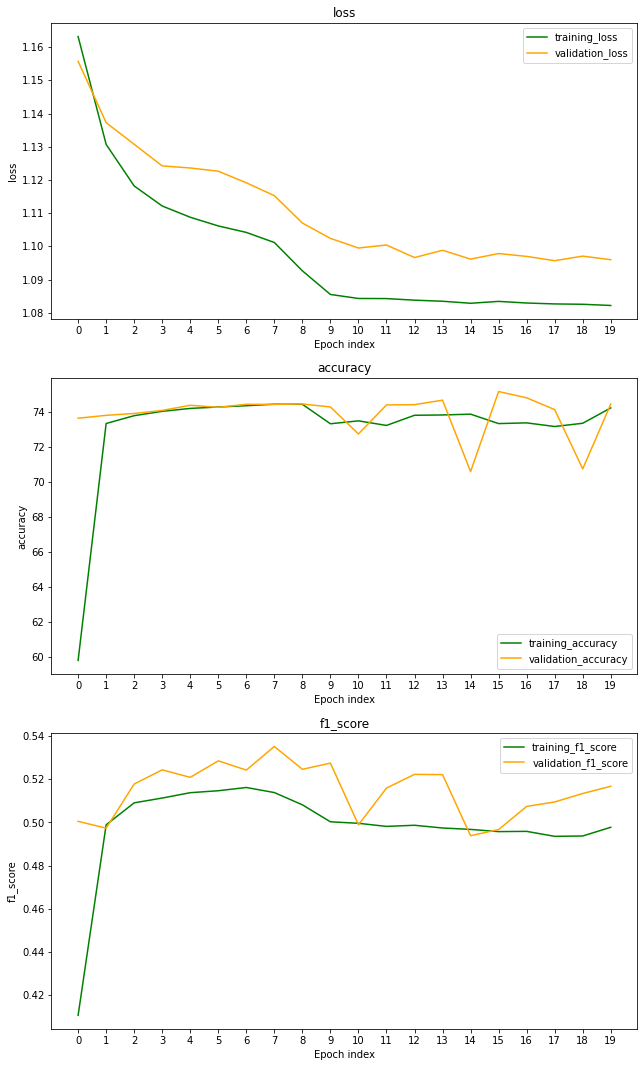

In [29]:
#  Entry point of this section

visualize_evaluation([
    (loss, 'loss'),
    (accuracy, 'accuracy'),
    (f1, 'f1_score'),],
    predictions,
    truth,
)

## 9. Save the model

In [30]:
def save_model(name, model):
    now = datetime.now()
    timestamp = now.strftime("%d%m_%H%M")

    filename = f'trained_{name}_model_{timestamp}.sav'
    pickle.dump(model, open(filename, 'wb'))

In [31]:
save_model('lstm', lstm_model)